# KFA45 postpulse study

See if the postpulse can be used as second kick: the pulse was set up to be 1 us long at the full power ~290 kV

In [19]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2018.05.15
Your IP is 172.17.0.13
2018-06-07 13:48:39
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [20]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [21]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.15'

matlabVars = ['PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [22]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 285 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.15/data/2018.05.15.17.48.56.194.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.05.15/data/2018.05.15.20.45.02.176.mat


In [23]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [24]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


## Restore the gate step array, that was not logged

In [25]:
sTime = 400 #ns
eTime = sTime + 150 #ns
step = 25 #ns
shotsN = 5 #per step

measSteps = np.arange(sTime, myDataFrame.shape[0]/shotsN * step + sTime, step)
measPts = np.sort(np.tile(measSteps, 5))

myDataFrame['startKFA45'] = measPts
myDataFrame['endKFA45'] = measPts+150 #ns

# Intensity

In [26]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][1300]/np.max(x) )

Text(0,0.5,u'Peak intensity (10^10 ppb)')

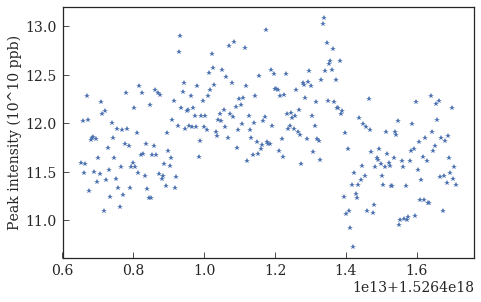

In [27]:
plt.plot(myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.ylabel('Peak intensity (10^10 ppb)')

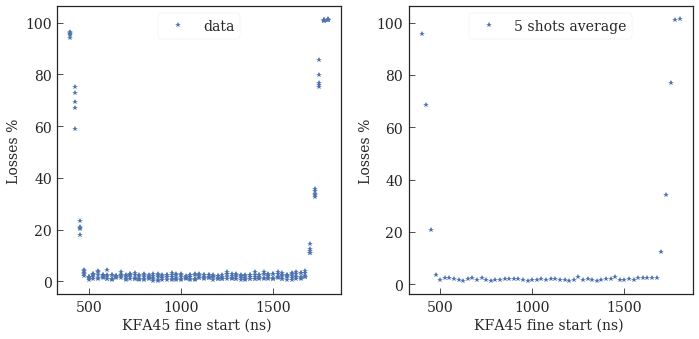

In [28]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# shot by shot
ax[0].plot(myDataFrame['startKFA45'],myDataFrame['Losses']*100,'*', label='data')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
ax[0].set_xlabel('KFA45 fine start (ns) ')
ax[0].set_ylabel('Losses %')
ax[0].legend(frameon=True)


#averaging losses at the same positions
theLoss = np.empty(0,dtype=float)
for k in np.arange(0,myDataFrame.shape[0],shotsN):
    theLoss = np.append(theLoss, np.mean(myDataFrame['Losses'].iloc[k:k+4]))

ax[1].plot(measSteps,theLoss*100,'*',label='5 shots average')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
ax[1].set_xlabel('KFA45 fine start (ns) ')
ax[1].set_ylabel('Losses %') 
ax[1].legend(frameon=True)

    
fig.tight_layout()

Text(0.5,1,u'10 shots intensity')

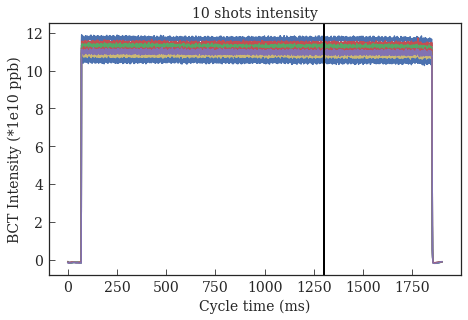

In [29]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[200+ll])
    
plt.axvline(x=1300, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# BPMs

In [30]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [31]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Calculate injection oscillation from the BPM

In [32]:
def signalRMS(x):
    return np.sqrt(np.sum((x-np.mean(x))**2) / len(x))

0.645870294641


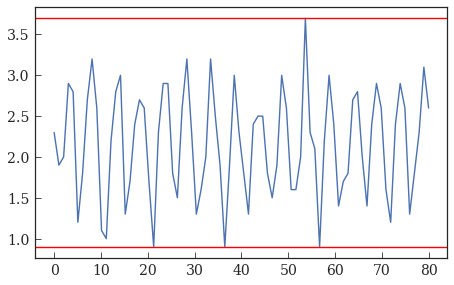

In [33]:
m=19 #BPM name
k=200 #shot number
xdata = np.linspace(0,80,80)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:80]).values[k]
plt.plot(xdata, ydata)
plt.axhline(y=max(ydata),color='r')
plt.axhline(y=min(ydata),color='r')
print(signalRMS(ydata))

ampl = []
for k in range(285):
    ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:80]).values[k]
    ampl.append(signalRMS(ydata))

(-14.200000000000001, 298.19999999999999, 0, 8)

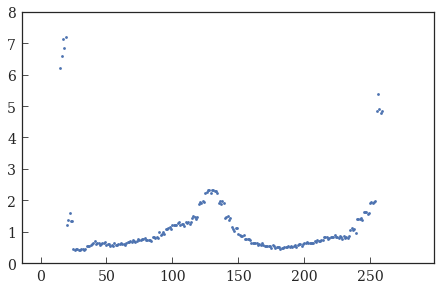

In [34]:
plt.plot(ampl,'.')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
# peak to peak orbit

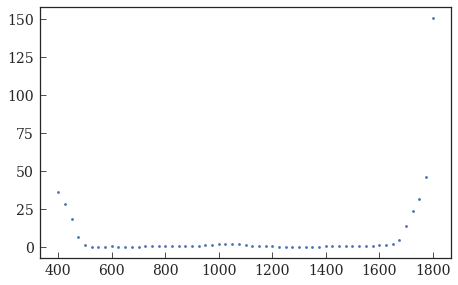

In [35]:
# averaging the 5 measurements
orbitP2P = np.empty(0,dtype=float)
for k in np.arange(0,myDataFrame.shape[0],shotsN):
    orbitP2P = np.append(orbitP2P, np.mean(ampl[k:k+4]))
    
plt.plot(measSteps, orbitP2P,'.')


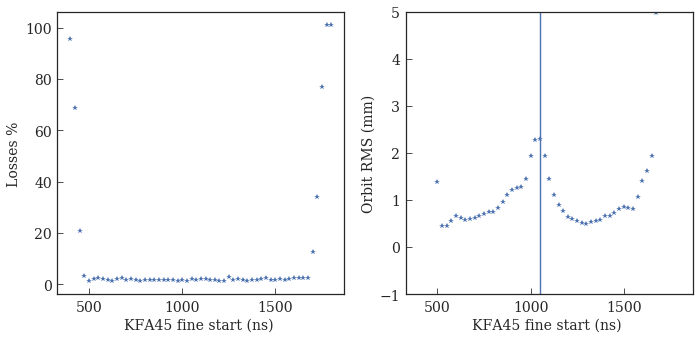

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

#averaging losses at the same positions
theLoss = np.empty(0,dtype=float)
for k in np.arange(0,myDataFrame.shape[0],shotsN):
    theLoss = np.append(theLoss, np.mean(myDataFrame['Losses'].iloc[k:k+4]))

ax[0].plot(measSteps,theLoss*100,'*',label='5 shots average')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
ax[0].set_xlabel('KFA45 fine start (ns) ')
ax[0].set_ylabel('Losses %') 
# ax[0].legend(frameon=True)

# considering peak to peak orbit
ax[1].plot(measSteps,orbitP2P,'*',label='5 shots average')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-1,5))
ax[1].set_xlabel('KFA45 fine start (ns) ')
ax[1].set_ylabel('Orbit RMS (mm)') 
# ax[1].legend(frameon=True)
ax[1].axvline(x=1050)

    
fig.tight_layout()

plt.savefig('Losses+orbitP2P.eps',dpi=100,format='eps')